Configurar matplotlib para ver las gráficas en linea

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from niwidgets import NiftiWidget
import ipywidgets as widgets
from nilearn import (image, plotting)
from nilearn.image.image import mean_img,load_img,index_img
from nilearn.input_data import NiftiMasker,NiftiLabelsMasker,NiftiMapsMasker
import os

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
results_path = "/data/elekin/data/results/fmri/preproc/"
dirs = next(os.walk(results_path))[1]
list_subjs = list(filter(lambda dir: "session" in dir,dirs))
len(list_subjs)

2

In [5]:
subj_id_selector = widgets.Select(
    options=list_subjs,
    # value='C575',
    # rows=10,
    description='Subject Id:',
    disabled=False
)
#subj_id_selector.on_trait_change(run_cells_below)
display(subj_id_selector)

Select(description='Subject Id:', options=('_session_id_1_subject_id_C021', '_session_id_1_subject_id_C578'), …

Lazy load del atlas y del archivo de neuroimagen para probar el atlas

In [6]:
fmri_root = "/data/elekin/data/origin/fmri/"
fsl_prob_cerebelo = fmri_root+"/TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz"
fsl_prob_cerebelo_3d = fmri_root+"/TEMPLATES/Cerebellum-MNIflirt-maxprob-thr0-1mm.nii.gz"
func_filenames = results_path+subj_id_selector.value+"/applyTransFunc/f1_trim_st_mcf_trans.nii.gz"
mni_template = fmri_root+"/TEMPLATES/MNI152_T1_3mm.nii.gz"
func_filenames

'/data/elekin/data/results/fmri/preproc/_session_id_1_subject_id_C578/applyTransFunc/f1_trim_st_mcf_trans.nii.gz'

NiftiMapsMasker para extraer las señales del cerebelo. NiftiMapsMasker es útil cuando se deben extraer datos de volúmenes superpuestos 

In [7]:
cbl_img = fsl_prob_cerebelo
masker = NiftiMapsMasker(maps_img=cbl_img, memory='nilearn_cache', verbose=True)
#masker = NiftiLabelsMasker(labels_img=cbl_img, memory='nilearn_cache', verbose=True)
#masker = NiftiMasker(mask_img=cbl_img, memory='nilearn_cache', verbose=True)#Needs binary mask

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


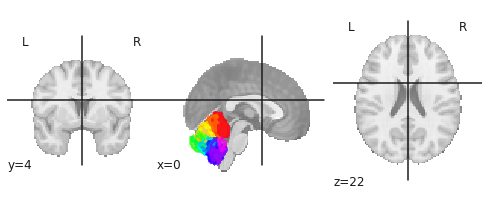

In [8]:
plotting.plot_prob_atlas(cbl_img, view_type='filled_contours')

Entrenamiento del modelo para aplicar la extracción del cerebelo

In [9]:
masker.fit()

[NiftiMapsMasker.fit] loading regions from /data/elekin/data/origin/fmri/TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz


NiftiMapsMasker(maps_img='/data/elekin/data/origin/fmri//TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz',
                memory='nilearn_cache', verbose=True)

Extracción de las series temporales dado el atlas de probabilidad del cerebelo a partir de las imágenes fmri.

In [10]:
timeseries_subject = masker.transform(func_filenames, confounds=None)

Resampling maps


/usr/local/lib/python3.8/dist-packages/nilearn/_utils/cache_mixin.py:307: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f248c470820>, interpolation='continuous', target_shape=(61, 73, 61), target_affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]))
_____________________________________________________resample_img - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/data/elekin/data/results/fmri/preproc/_session_id_1_subject_id_C578/applyTransFunc/f1_trim_st_mcf_trans.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7f2416d98e20>, { 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_p

Gráfica de las 28 series temporales extraidas

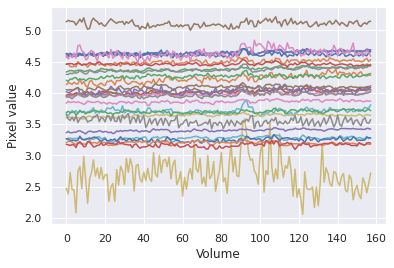

In [11]:
fig = plt.figure()
plt.plot(timeseries_subject)
plt.xlabel('Volume')
plt.ylabel('Pixel value')
plt.show()

In [12]:
len(timeseries_subject[0])

28

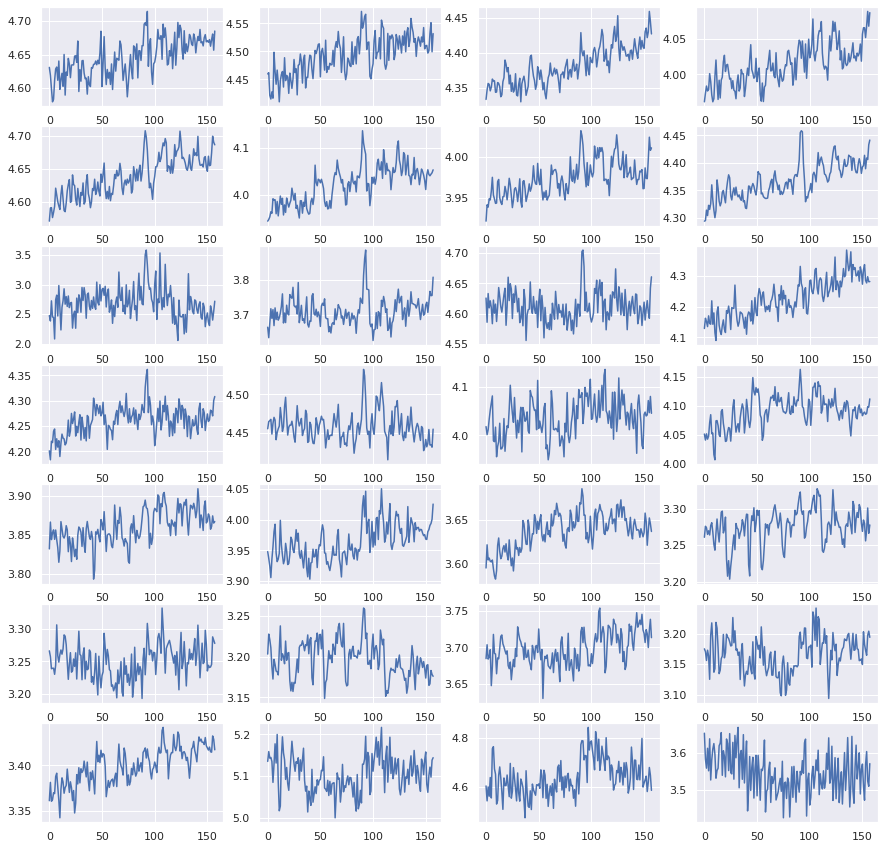

In [13]:
from matplotlib import cm

plt.figure(figsize=(15.,15.))
for i,ts in enumerate(timeseries_subject.T):
    plt.subplot(7, 4, i+1)
    plt.plot(ts, label=i+1)

In [14]:
timeseries_subject.shape

(158, 28)

In [15]:
cbl_subject = masker.inverse_transform(timeseries_subject)

[NiftiMapsMasker.inverse_transform] computing image from signals


In [16]:
print(cbl_subject)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 158)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91 158   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code

In [18]:
cbl_widget = NiftiWidget(cbl_subject)
_ = cbl_widget.nifti_plotter()

interactive(children=(IntSlider(value=45, continuous_update=False, description='x', max=90), IntSlider(value=5…

<Figure size 432x288 with 0 Axes>